## Project 1 Hotdog -- no hotdog
This project is a simple web application that uses a convolutional neural network (CNN) model to classify images as "hotdog" or "not hotdog". 

In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [27]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='../../../datasets/hotdog_nothotdog'):  # Update this path
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]

        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y
    


Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [28]:
size = 128  # Keep your original size or change to 224 as in your example

# ENHANCED: Training transforms with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip horizontally
    transforms.RandomRotation(degrees=15),    # Rotate by up to 15 degrees
    transforms.ColorJitter(
        brightness=0.1,    # ±20% brightness variation
        contrast=0.1,      # ±20% contrast variation
    ),
    transforms.RandomResizedCrop(size, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Center at 0.5 for each RGB channel
                        std=[0.5, 0.5, 0.5])     # Scale to [-1, 1] range
])

# Keep test transforms simple (no augmentation for testing)
test_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Center at 0.5 for each RGB channel
                        std=[0.5, 0.5, 0.5])     # Scale to [-1, 1] range
])
batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
print(trainset.image_paths)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)  # Changed to 0
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)  # Changed to 0

['../../../datasets/hotdog_nothotdog/train/nothotdog/people (158).jpg', '../../../datasets/hotdog_nothotdog/train/nothotdog/food (296).jpg', '../../../datasets/hotdog_nothotdog/train/nothotdog/people (55).jpg', '../../../datasets/hotdog_nothotdog/train/nothotdog/people (334).jpg', '../../../datasets/hotdog_nothotdog/train/nothotdog/food (97).jpg', '../../../datasets/hotdog_nothotdog/train/nothotdog/pets (248).jpg', '../../../datasets/hotdog_nothotdog/train/nothotdog/food (150).jpg', '../../../datasets/hotdog_nothotdog/train/nothotdog/food (384).jpg', '../../../datasets/hotdog_nothotdog/train/nothotdog/pets (136).jpg', '../../../datasets/hotdog_nothotdog/train/nothotdog/pets (566).jpg', '../../../datasets/hotdog_nothotdog/train/nothotdog/furniture (146).jpg', '../../../datasets/hotdog_nothotdog/train/nothotdog/pets (589).jpg', '../../../datasets/hotdog_nothotdog/train/nothotdog/pets (423).jpg', '../../../datasets/hotdog_nothotdog/train/nothotdog/food (107).jpg', '../../../datasets/hotdo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].


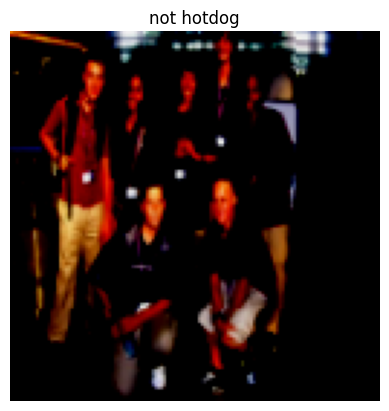

In [30]:
# Show a sample image from the trainset after transform to check for distortion
img, label = trainset[0]
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.title(['hotdog', 'not hotdog'][label])
plt.axis('off')
plt.show()

How much data do we have by default? Do we need to augment it?

In [31]:
train_image_count = len(train_loader.dataset)
test_image_count = len(test_loader.dataset)

print(f"Number of training images: {train_image_count}")
print(f"Number of test images: {test_image_count}")

Number of training images: 2047
Number of test images: 1862


Let's look at some images from our data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.43529415].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input d

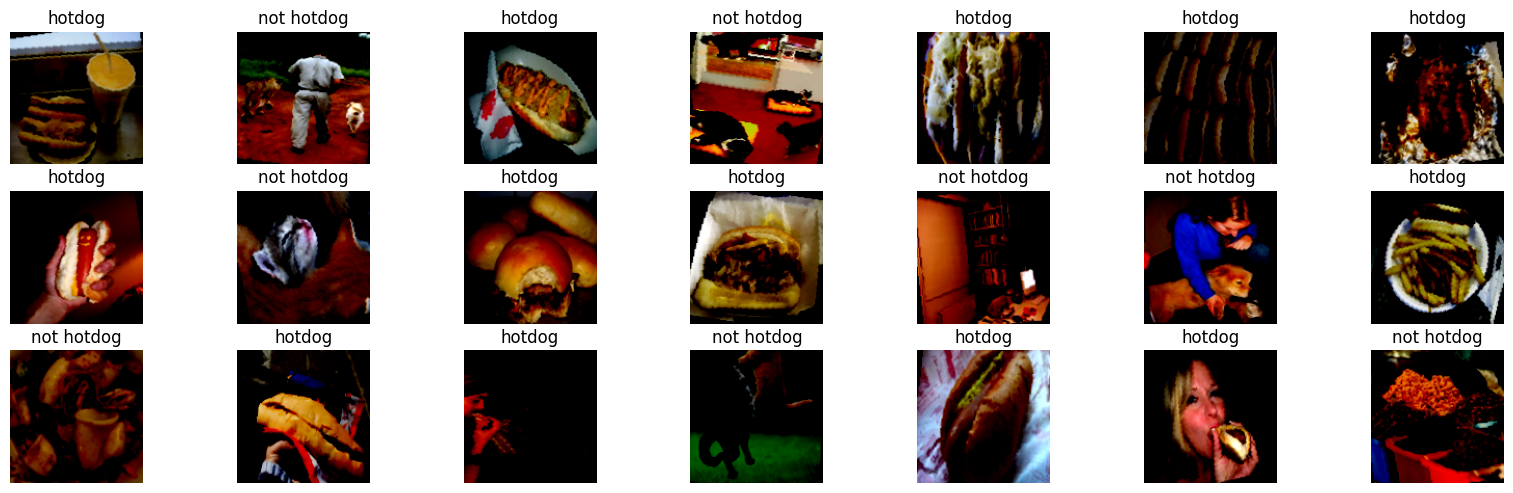

In [32]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


Inspiration from lectures:
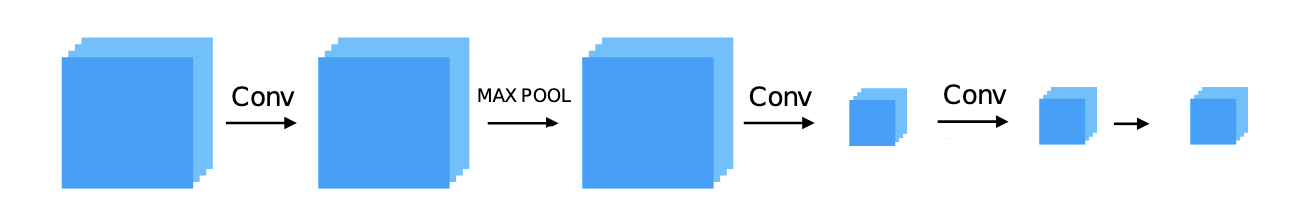

Thoughts regarding the architecture:
- to conv -> maxpool -> to conv -> FC
- Binary classification (needs to be reduced to one output).
- Hot-dog images are in RGB, meaning it has 3 channels

Layer 1 (convolutional):
- Here, kernel size is 3x3, and the stride and padding are both one, to retain the dimensionality of the images.
- First convolution captures basic structures, while the second convolution learns more complex and non-linear structures.
- Maxpooling 2x2 with a stride of 2 is performed. This is to half the size of the image so 128x128 -> 64x64. Makes the model generalise better, and less computational.
- Third convolution has kernel size of 3x3, with stride and padding of 1. This layer increases channels, such that the detail is greater. Fourth convolution captures non-linearies from the maxpooled size.
- This structure has inspired from what has been discussed in lectures, and uses the receptive field in order to remember the structure in later layers.

Layer 2 (Fully connected)
- Firstly, the layer converts the feature maps to one long vector per image. This is because the fully-connected network requires a vector.
- The change from 16*64*64 to 128 and through ReLU makes the information learned compact, and this because the linear combination on which the classifier predicts.
- Finally, the 128 neurons are passed through only two neurons, either hotdog or no-hotdog.

Additional comments:
- Because we used CrossEntropyLoss, it was not relevant to apply an activation function to the end result.

In [33]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
            # First block: 32 filters
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128x128 -> 64x64

            # Second block: 64 filters
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64 -> 32x32

            # Third block: 128 filters
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)   # 32x32 -> 16x16
        )

        self.fully_connected = nn.Sequential(
            nn.Flatten(),  # Alternative to x.view() in forward
            nn.Linear(128 * 16 * 16, 128),  # 128 channels * 16 * 16 = 32,768
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),  # Single output for binary classification
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

    def forward(self, x):
        x = self.convolutional(x)
        x = self.fully_connected(x)
        return x

In [34]:
model = Network()
model.to(device)

# Use Adam optimizer with lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Get the first minibatch - FIXED: use device instead of .cuda()
data = next(iter(train_loader))[0].to(device)
# Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
model(data)  # if this runs the model dimensions fit

Shape of the output from the convolutional part torch.Size([64, 128, 16, 16])


tensor([[0.5722],
        [0.5295],
        [0.5029],
        [0.6559],
        [0.4105],
        [0.5001],
        [0.4690],
        [0.5903],
        [0.5283],
        [0.5675],
        [0.3693],
        [0.4834],
        [0.4967],
        [0.5645],
        [0.5589],
        [0.5601],
        [0.4705],
        [0.5356],
        [0.6208],
        [0.4860],
        [0.5285],
        [0.7168],
        [0.4999],
        [0.3649],
        [0.5774],
        [0.5198],
        [0.6313],
        [0.6255],
        [0.4888],
        [0.5433],
        [0.5273],
        [0.7184],
        [0.6128],
        [0.6323],
        [0.3864],
        [0.6218],
        [0.5117],
        [0.4431],
        [0.2946],
        [0.4361],
        [0.4306],
        [0.5055],
        [0.4571],
        [0.4872],
        [0.5440],
        [0.6213],
        [0.6146],
        [0.4343],
        [0.3773],
        [0.5456],
        [0.5896],
        [0.5714],
        [0.6618],
        [0.4099],
        [0.4756],
        [0

Training and testing of the model


In [35]:
num_epochs = 10  # Increased for better training
criterion = nn.BCELoss()  # Made for binary classification, Binary Cross Entropy for sigmoid output

for epoch in tqdm(range(num_epochs), unit='epoch'):
    model.train()  # Set training mode
    train_correct = 0
    train_loss = 0
    
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        
        # FIXED: Convert target to float and reshape for BCELoss
        target = target.float().unsqueeze(1)  # Shape: [batch_size, 1]
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Compute the loss
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()

        # FIXED: Compute accuracy for binary classification with sigmoid
        predicted = (output > 0.5).float()  # Threshold at 0.5
        train_correct += (target == predicted).sum().item()
        train_loss += loss.item()
    
    # FIXED: Test evaluation
    model.eval()  # Set evaluation mode
    test_correct = 0
    with torch.no_grad():  # Disable gradients for evaluation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target = target.float().unsqueeze(1)  # Same conversion for test
            
            output = model(data)
            predicted = (output > 0.5).float()  # Threshold at 0.5
            test_correct += (target == predicted).sum().item()
    
    # Calculate accuracies
    train_acc = train_correct / len(trainset)
    test_acc = test_correct / len(testset)
    avg_loss = train_loss / len(train_loader) 
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Loss: {avg_loss:.4f}")  
    print(f"Accuracy - Train: {train_acc*100:.1f}%\t Test: {test_acc*100:.1f}%")
    print("-" * 50)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/10
Loss: 1.0155
Accuracy - Train: 65.8%	 Test: 72.3%
--------------------------------------------------


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/10
Loss: 0.6049
Accuracy - Train: 70.9%	 Test: 75.5%
--------------------------------------------------


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/10
Loss: 0.5437
Accuracy - Train: 75.2%	 Test: 73.9%
--------------------------------------------------


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/10
Loss: 0.5390
Accuracy - Train: 75.2%	 Test: 76.5%
--------------------------------------------------


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/10
Loss: 0.4853
Accuracy - Train: 78.4%	 Test: 77.1%
--------------------------------------------------


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/10
Loss: 0.4697
Accuracy - Train: 78.4%	 Test: 77.1%
--------------------------------------------------


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/10
Loss: 0.4590
Accuracy - Train: 80.9%	 Test: 77.7%
--------------------------------------------------


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/10
Loss: 0.4732
Accuracy - Train: 79.7%	 Test: 77.8%
--------------------------------------------------


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/10
Loss: 0.4402
Accuracy - Train: 81.1%	 Test: 78.3%
--------------------------------------------------


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/10
Loss: 0.4216
Accuracy - Train: 81.0%	 Test: 79.2%
--------------------------------------------------


In [ ]:
epochs = range(1, len(train_acc) + 1)
# plt.plot(epochs, out_dict["train_acc"], label="Train acc")
# plt.plot(epochs, out_dict["test_acc"], label="Test acc")
plt.plot(epochs, out_dict["train_loss"], label="Train loss")
plt.plot(epochs, out_dict["test_loss"], label="Test loss")

plt.legend()
plt.title("Training and Test Loss Over Epochs")
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

In [38]:
def smoothgrad(model, image, class_idx, n_samples=50, stdev=0.15):
    """
    Compute SmoothGrad saliency map for an image.
    
    Args:
        model: PyTorch model (e.g., ResNet)
        image: Input tensor, shape (1, C, H, W), requires_grad=True
        class_idx: Integer index of the target class
        n_samples: Number of noisy samples to average
        stdev: Standard deviation of Gaussian noise
    Returns:
        saliency_map: Averaged gradient map, shape (C, H, W)
    """
    model.eval()
    image = image.clone().detach().requires_grad_(True)
    saliency_maps = []

    for _ in range(n_samples):
        # Add Gaussian noise
        noise = torch.randn_like(image) * stdev
        noisy_image = image + noise
        noisy_image.requires_grad_(True)
        
        # Forward pass
        output = model(noisy_image)
        # Get score for target class
        score = output[0, class_idx]
        
        # Backward pass to compute gradients
        score.backward()
        # Get absolute gradients
        gradients = noisy_image.grad.abs().detach()
        saliency_maps.append(gradients.cpu())
        
        # Clear gradients
        noisy_image.grad.zero_()
    
    # Average the gradients
    saliency_map = torch.stack(saliency_maps).mean(dim=0)
    return saliency_map

# Example usage
from torchvision.models import resnet50
import torchvision.transforms as T
from PIL import Image

# Load pre-trained model
model = resnet50(pretrained=True).eval()
# Load and preprocess image (example: single RGB image)
image = trainset[1]
transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
# image_tensor = transform(image).unsqueeze(0)  # Shape: (1, 3, 224, 224)

# Compute SmoothGrad for class index 281 (e.g., "tabby cat" in ImageNet)
saliency_map = smoothgrad(model, image_tensor, class_idx=281)

# Visualize (convert to numpy for plotting, e.g., with matplotlib)
import matplotlib.pyplot as plt
saliency_map_np = saliency_map.squeeze().numpy()
plt.imshow(saliency_map_np.mean(axis=0), cmap="hot")
plt.axis("off")
plt.show()

NameError: name 'image_tensor' is not defined